<a href="https://www.coursera.org/learn/applied-data-science-capstone/"><img src = "https://seetorontonow.mx/uploads/2018/01/kayak-on-lake-ontario-looking-at-toronto-skyline.jpg" width = 500> </a>

<h1 align=center><font size = 5>Segmenting and Clustering Neighborhoods in Toronto</font></h1>
<h1 align=center><font size = 4>By Miguel Lira Vidrio</font></h1>
<h1 align=center><font size = 2.5>For Coursera Applied Data Science Capstone</font></h1>

## Introduction
In this notebook is presented a work around Toronto Neighborhoods to understand their characteristics and segmenting them.
The neighborhoods information was obteined from Wikipedia (https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) and grouping by Postalcode. Also the geo coordinates was added to each Postalcode. The Foursquare API was used to get venues around of the PostalCode Coordinates. With the collected information a dataframe was built and included top 10 venues categories for each postalcode, venues density per square meters. Finally we applied a kmeans algorithm.  

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Create Toronto Neighborhoods Dataframe</a>

2. <a href="#item2">Get PostalCode Coordinates</a>

3. <a href="#item3">Get Venues from Foursquare API</a>

4. <a href="#item4">Cluster PostalCodes</a>

5. <a href="#item5">Examine Results</a>    
</font>
</div>

##### Install and import libraries:

In [1]:

!pip install tensorflow
!pip install geopy
!pip install folium
!pip install bs4
!pip install googlemaps
!pip install plotly
!pip install cufflinks

    100% |████████████████████████████████| 1.6MB 15.9MB/s ta 0:00:01��███████████████▋  | 1.5MB 55.6MB/s eta 0:00:01
    100% |████████████████████████████████| 890kB 23.5MB/s ta 0:00:01
  Running setup.py bdist_wheel for html5lib ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: html5lib 0.999999999
    Uninstalling html5lib-0.999999999:
      Successfully uninstalled html5lib-0.999999999
  Found existing installation: bleach 2.0.0
    Uninstalling bleach-2.0.0:
      Successfully uninstalled bleach-2.0.0
    100% |████████████████████████████████| 92kB 14.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for bs4 ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
  Running setup.py bdist_wheel for googlemaps ... done
  Stored in directory: /home/dsxuser/.cache/

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import json
from pandas.io.json import json_normalize
import folium # plotting library
from bs4 import BeautifulSoup #Library to scraping info. from a web portal such a wikipedia.


print('Libraries are correctly imported')

Libraries are correctly imported


## 1. Create Toronto Neighborhoods DataFrame

The Toronto Neighborhoods information is available in the following Wikipedia Page: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M 
BeautifulScrape was used to scrape the table content. A pandas dataframe was built from content in order to know which Neighborhoods belongs to a PostalCode and Borough with the follow structure:
<img src="https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/7JXaz3NNEeiMwApe4i-fLg_40e690ae0e927abda2d4bde7d94ed133_Screen-Shot-2018-06-18-at-7.17.57-PM.png?expiry=1559779200000&hmac=dyAVJgKU6e2BrXIIHUTkjX3L4kgDdkzjFF2IEV6tmP4" width = 400>

In the table on the Wikipedia page, is possible see that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. For our purpuse these two rows was combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

Also the Wikipedia table has PostalCode with Not assigned Boroughs and Neighborhoods. The analysis required process the cells that had an assigned borough. When a PostalCode had borough but a Not assigned neighborhood, the neighborhood was replaced with borough name. 

In the next cells the code to create the desire dataframe is presented.


1) Toronto Neighborhood Data from Wikipedia was processed to a Dataframe.

In [3]:
#Scrape content from Wikipedia table:
url=requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup=BeautifulSoup(url,"html.parser")
tb = soup.find('table', class_='wikitable')
rows = tb.find_all('tr')
l = []
for tr in rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    l.append(row)
#Create a pandas dataframe: 
toronto_df=pd.DataFrame(l, columns=["PostalCode", "Borough","Neighborhood"])
toronto_df=toronto_df.drop([0])
toronto_df=toronto_df.reset_index(drop=True)
#Replace dirty string:
toronto_df["Neighborhood"]=toronto_df["Neighborhood"].str.replace('\n', '')

2) Only assigned Boroughs were selected. All "Not assigned" Neighborhood records were replaced with the correspondent Borough name.

In [4]:
totalPost=toronto_df["PostalCode"].unique().shape[0]
toronto_df=toronto_df.loc[toronto_df["Borough"]!="Not assigned"]
index=toronto_df.loc[toronto_df["Neighborhood"]=="Not assigned"].index.values.astype(int)
for i in index:
    toronto_df.at[i, 'Neighborhood'] = toronto_df.at[i, 'Borough']
PC=toronto_df["PostalCode"].unique().shape[0]
PC_na_Boroughs=totalPost-PC

3) Adjusted DataFrame to contains Borough, Postalcode and a list of related Neighborhoods separated with coma.

In [5]:
toronto_df=toronto_df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(lambda x:"%s" % ", ".join(x)).to_frame()
toronto_df.reset_index(level=1, inplace=True)
toronto_df.reset_index(level=0, inplace=True)

4) In the follow cell the results from the code are presented:

In [6]:
print("At the beginning we had: {} Postalcodes.".format(totalPost))
print('A total of {} PostalCodes was discarded.'.format(PC_na_Boroughs))
print("Only {} Neighborhoods was replaced with the Borough Name.".format(index.shape[0]))
print("The final shape of our dataframe is {}".format(toronto_df.shape))

At the beginning we had: 180 Postalcodes.
A total of 77 PostalCodes was discarded.
Only 1 Neighborhoods was replaced with the Borough Name.
The final shape of our dataframe is (103, 3)


In [7]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
69,M5W,Downtown Toronto,Stn A PO Boxes 25 The Esplanade
79,M6L,North York,"Downsview, North Park, Upwood Park"
38,M4G,East York,Leaside
31,M3L,North York,Downsview West
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
14,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St..."
76,M6H,West Toronto,"Dovercourt Village, Dufferin"
99,M9P,Etobicoke,Westmount


## 2. Get PostalCode Coordinates

The dataframe created with Wikipedia table content do not possess coordinates for every single PostalCode. Unfortunately, the foursquare API works better with coordinates.
Googlemaps library was used to get latitude and longitude coordinates for each PostalCode. In the cells below the steps followed to get coordinates are presented.

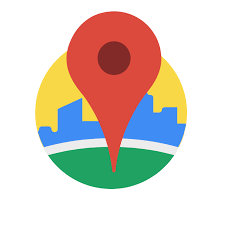

1) First the googlemaps library was added. Also in order to obtain better results in the location of coordinates directions variable was created.

In [8]:
import googlemaps
directions=toronto_df["PostalCode"]+ ", ONTARIO, CANADA"

2) The Google Cloud Secret Key was specified.

In [9]:
# The code was removed by Watson Studio for sharing.

3) Latitude and longitude were got from grocode API and added to the Toronto_Neighborhood Dataframe.

In [10]:
gmaps = googlemaps.Client(key=my_key)
i=len(directions)
lat=np.zeros(i)
long=np.zeros(i)
for j in range(i):
    direction=directions[j]
    geocode_result = gmaps.geocode(direction)
    lat[j]=geocode_result[0]["geometry"]["location"]["lat"]
    long[j]=geocode_result[0]["geometry"]["location"]["lng"]
toronto_df["Latitude"]=lat
toronto_df["Longitude"]=long

4) In the next cell is possible see the resultant dataframe from the code above.

In [11]:
toronto_df.sample(n=10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
76,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556
19,M2K,North York,Bayview Village,43.786947,-79.385975
16,M1X,Scarborough,Upper Rouge,43.836125,-79.205636
81,M6N,York,"The Junction North, Runnymede",43.673185,-79.487262
91,M8Y,Etobicoke,"Humber Bay, King's Mill Park, Kingsway Park So...",43.636258,-79.498509
87,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558
68,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420
13,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter",43.781638,-79.304302
99,M9P,Etobicoke,Westmount,43.696319,-79.532242


## 3. Get Veneus from Foursquare API

This section contains the steps followed to get venues from Foursquare in a properly way. Initially it was thought to work the parameters defined in the Segmenting and Clustering New York Neighborhoods I mean 500 meters of radius in every search. To not take risks this section has two parts:

1) Data exploration and refinement
2) Get Venues from Foursquare.


<img src="https://ss0.4sqi.net/img/developers/products/places-api-538e392a138bea16aa61260a55a875b4.png" width = 200>


#### 3.1. Data Exploration

1) Firstly a folium map was generated to understand the Toronto PostalCodes distribution.

In [12]:
address = 'Toronto, ONTARIO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of TORONTO City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of TORONTO City are 43.653963, -79.387207.


In [13]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    
Toronto_map

2) The parameter used in New York Neighborhoods (radius=500 meters) was added to Toronto_map

In [14]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and radius to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=500,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

As the first Toronto Map shown, is confirmed in the map above that in many Postalcode a radius of 500 meters could left behind a lot of venue. Is possible identify a lot of Postalcode overlaping.
To solve the radius problem the GeoPy.Distance.greatCircle was used.

##### Additional Information about how get an properly radius:
Nearest Location:
https://stackoverflow.com/questions/49323171/find-the-nearest-location-using-numpy
Geopy.distance example:
https://www.programcreek.com/python/example/96855/geopy.distance.vincenty
Best way to compute distance:
https://geopy.readthedocs.io/en/stable/#module-geopy.distance


3) The Geopy.Distance.Greatcircle library was loaded and a function to find the nearest postalcode for each location was created.

In [15]:
from geopy.distance import great_circle
def find_closest_location(origin, locations):
    locations=np.asarray(locations)
    origin=np.asarray(origin).reshape(1,-1)
    i=len(locations)
    distances=np.zeros(i)
    for j in range(i):
        distances[j] = great_circle(origin, locations[j]).meters
    closest = np.argmin(distances)
    return [round(distances[closest]), closest]

Once the function was created a test was performed to know if the gottan data was correct.

In [16]:
locations=toronto_df[["Latitude", "Longitude"]]
meters, index=find_closest_location(locations[:1], locations[~locations.index.isin([0])])
close_point = locations[:1].append(locations[index+1:index+2])
points=np.asarray(close_point)
print("The distance between {} postalcode and the nearest neighbor ({} postalcode) is: {} meters".format(toronto_df["PostalCode"][0],toronto_df["PostalCode"][index+1], meters) )

The distance between M1B postalcode and the nearest neighbor (M1X postalcode) is: 3397.0 meters


In the output cell below is possible see a map that shows the results from the tested PostalCode above.
The tested PostalCode and its nearest neighbor was drawed in red and is possible locate them into the top right corner.

In [17]:
test_data=toronto_df
i=len(test_data)
tested=np.zeros(i)
tested[0]=1
tested[index+1]=1
tested=np.int64(tested)
test_data["Test"]=tested
colors = ["blue", "red"]
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers and radius to map
for lat, lng, borough, neighborhood, tested in zip(test_data['Latitude'], test_data['Longitude'], test_data['Borough'], test_data['PostalCode'], test_data["Test"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color=None,
        fill=True,
        fill_color=colors[tested],
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)
folium.PolyLine(points, color="red", label = meters, weight=2.5, opacity=1).add_to(Toronto_map)
Toronto_map 


4) In order to get the radius computed from the distance to nearest neighbor a iterate function was defined.

In [18]:
def get_radius(df, locations):
    for lat, lng, idx in zip(df['Latitude'], df['Longitude'], df.index):
        meters, index = find_closest_location([lat,lng], locations[~locations.index.isin([idx])])
        df.at[idx,'Radius'] = np.int64(meters//2) 
    return df

5) In the next steps a new dataframe with a new variable "Radius" was gotten.

In [19]:
toronto_df=toronto_df[["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]]
df_4square=get_radius(toronto_df, locations)
df_4square.head(12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Radius
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1302.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1113.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1113.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


In [20]:
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radius to map
for lat, lng, borough, neighborhood, r in zip(df_4square['Latitude'], df_4square['Longitude'], df_4square['Borough'], df_4square['Neighborhood'], df_4square["Radius"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(Toronto_map) 
Toronto_map

In the deployed map above is easy to identify that the circles have better definition. 

#### 3.2 Get venues from Foursquare API

In the cells below the New York Lab code was replicated in order to get venues in every single postal code. After the venues data was collected a data preparation work was developed. Finally a venues dataframe is presented.

1) The new york lab function to get until 100 venues in the specified latitude and longitude coordinates aroud a certain radius was defined in this notebook. Is important to note that a couple of little changes was made: first the radius now is not a fix parameter but is a variable, second the total number of venues is now available from the function output.
For the work made it in the next section is important the resultant dataframe contain additional information than its predecessor, particularly radius and total venues per postalcode.

In [21]:
def getNearbyVenues(ID, latitudes, longitudes, radius):
    venues_list=[]
    for i, lat, lng, r  in zip(ID, latitudes, longitudes, radius ):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            r, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        total=results["response"]["totalResults"]
        results=results["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            i,
            r,
            total,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',"Radius","#_Venues",'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

    return(nearby_venues)

2) Foursquare API credentials, version, the highest number of venues and variables needed to query venues from foursquarewas especified.

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
ID=df_4square["PostalCode"]
latitudes=df_4square['Latitude']
longitudes=df_4square['Longitude']
radius=df_4square["Radius"]

4) In the follow cells the GetNearbyVenues function was executed and the venues for each PostalCode were gotten from the Foursquare API. The results are presented in a table with sample data and a resume from the query.  

In [24]:
venues = getNearbyVenues(ID, latitudes, longitudes, radius)

In [25]:
venues.sample(n=5)

,PostalCode,Radius,#_Venues,Venue,Venue Latitude,Venue Longitude,Venue Category
1254,M4K,651.0,81,Urban Nails,43.676668,-79.356602,Spa
397,M1V,1480.0,65,Saravanaa Bhavan South Indian Restaurant,43.810117,-79.269275,Indian Restaurant
2512,M6J,703.0,113,Hello 123,43.643264,-79.423516,Vegetarian / Vegan Restaurant
2453,M6J,703.0,113,Dakota Tavern,43.649680,-79.420838,Bar
2069,M5R,601.0,34,Schmaltz Appetizing,43.673895,-79.411818,Deli / Bodega


In [26]:
print('There are a totall Toronto postcodes:', df_4square['PostalCode'].shape[0])
print('And the total Toronto postcodes with gotten venues:', venues['PostalCode'].unique().shape[0])
print("Finally there are {} venues distributed on {} Categories.".format(venues.shape[0], venues["Venue Category"].unique().shape[0]))

There are a totall Toronto postcodes: 103
And the total Toronto postcodes with gotten venues: 102
Finally there are 3326 venues distributed on 324 Categories.


At these point the dataframe with the gotten venues was ready to start with the data analysis and Segmentation model.

## 4. Cluster PostalCodes

In this section the working with Toronto Venues DataFrame and the clustering k-means algorithm implementation is presented. For this purpose the section has been divided into 3 clear parts:
1) PostalCode Venues exploration
2) Clustering DataFrame
3) K-Means Implementation

<img src="https://static.thenounproject.com/png/1551503-200.png" width = 200>


In [27]:
# use the inline backend to generate the plots within the browser
import matplotlib as mpl
import matplotlib.pyplot as plt
print(plt.style.available)
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

['seaborn-paper', '_classic_test', 'seaborn-whitegrid', 'grayscale', 'seaborn-pastel', 'seaborn-talk', 'seaborn-white', 'dark_background', 'fivethirtyeight', 'fast', 'Solarize_Light2', 'seaborn-bright', 'seaborn-dark', 'seaborn', 'seaborn-colorblind', 'seaborn-notebook', 'classic', 'seaborn-ticks', 'seaborn-darkgrid', 'seaborn-muted', 'seaborn-dark-palette', 'bmh', 'seaborn-deep', 'ggplot', 'seaborn-poster']


#### 3.1. Data Audit
In the cells below the code to identify the top venues categories for Toronto and each PostalCode is presented. 

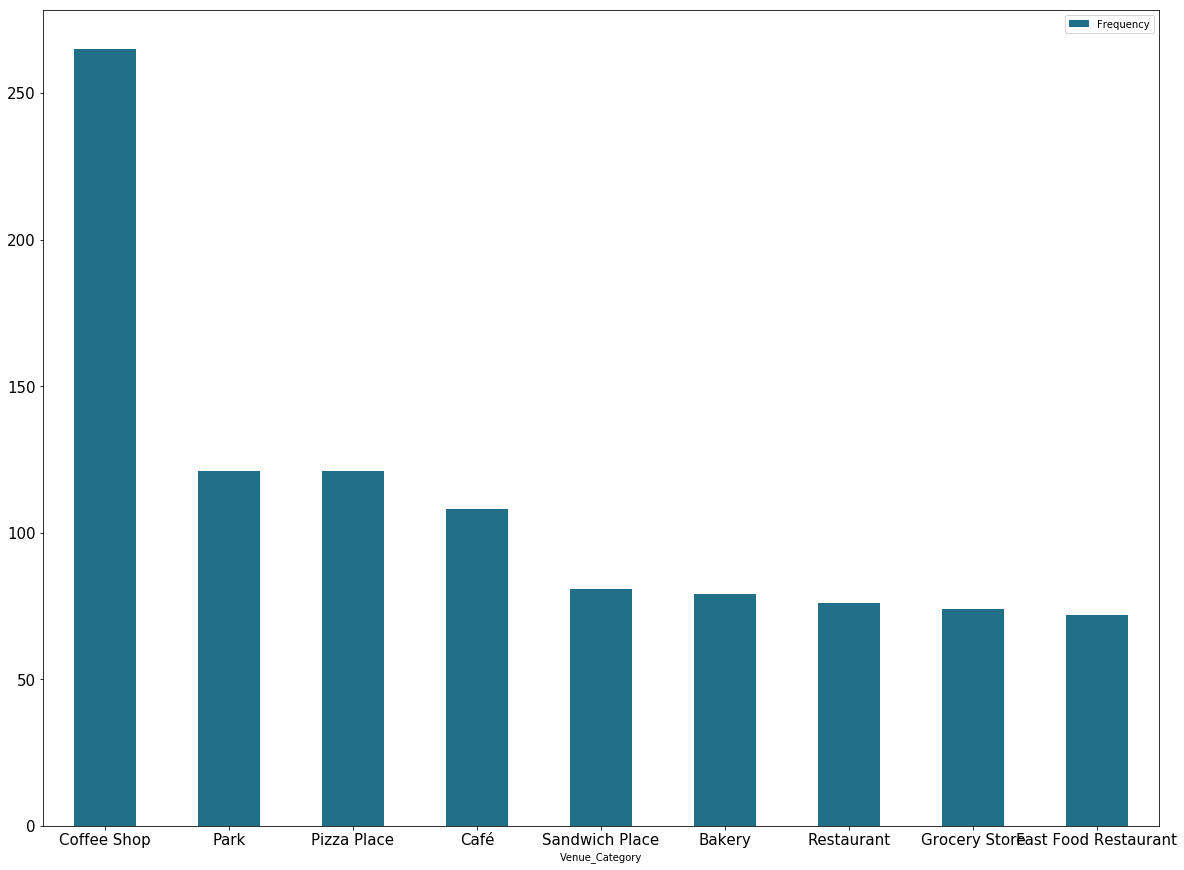

In [28]:
df_top10=df_top10=pd.DataFrame(venues['Venue Category'].value_counts()).reset_index(drop=False)[0:9]
df_top10.columns=["Venue_Category", "Frequency"]
x=df_top10.plot.bar(x="Venue_Category", y="Frequency", rot=0, figsize=(20,15), stacked=False, color="#216F89", fontsize=15)


In the next cell a report with the top 5 venues cetegories for each PostalCode is presented. Also, the dataframe for clustering porpuses was prepared by using the code from the New York Lab. 

In [29]:
indicators = ['st', 'nd', 'rd']
# one hot encoding
toronto_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot["PostalCode"] = venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_grouped=toronto_onehot.groupby('PostalCode').mean().reset_index()
num_top_venues = 5

for hood in toronto_grouped['PostalCode']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['PostalCode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----M1B----
                  venue  freq
0           Zoo Exhibit  0.58
1  Fast Food Restaurant  0.08
2           Pizza Place  0.06
3      Video Game Store  0.03
4           Coffee Shop  0.03


----M1C----
            venue  freq
0     Pizza Place   0.2
1  Breakfast Spot   0.1
2    Neighborhood   0.1
3        Pharmacy   0.1
4   Grocery Store   0.1


----M1E----
                  venue  freq
0           Pizza Place  0.15
1  Fast Food Restaurant  0.08
2        Breakfast Spot  0.08
3           Coffee Shop  0.08
4        Discount Store  0.04


----M1G----
               venue  freq
0        Coffee Shop  0.50
1               Park  0.25
2           Pharmacy  0.25
3  Accessories Store  0.00
4        Music Venue  0.00


----M1H----
               venue  freq
0             Bakery  0.12
1  Indian Restaurant  0.08
2        Coffee Shop  0.08
3           Pharmacy  0.08
4   Asian Restaurant  0.04


----M1J----
                  venue  freq
0        Sandwich Place  0.18
1  Fast Food Restaurant  0.14


In [30]:
print("After run the New York Lab Code, the Toronto PostalCode DataFrame for clustering analysis had a shape {}".format(toronto_grouped.shape))

After run the New York Lab Code, the Toronto PostalCode DataFrame for clustering analysis had a shape (102, 325)


#### 3.2. Data Preparation
At this point the DataFrame for clustering purposes are prepared. The DataFrame shape shows that maybe a lot of distortions could be generated.
In order to get a better analysis new DataFrame with the resume of each PostalCode was created.  The resume was prepared with two variables: Radius and Number of Venues Recovered from Foursquare. The work around is shown in the cells below.

Additional information about how the K-Means algorithm works and its data requierments is presented in the follow links:
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html;
https://www.quora.com/Why-does-K-means-clustering-perform-poorly-on-categorical-data-The-weakness-of-the-K-means-method-is-that-it-is-applicable-only-when-the-mean-is-defined-one-needs-to-specify-K-in-advance-and-it-is-unable-to-handle-noisy-data-and-outliers


In [31]:
clustering_toronto=venues[venues.duplicated(["PostalCode"], keep="first")==False]
clustering_toronto.reset_index(inplace=True, drop=True)
clustering_toronto=clustering_toronto[["PostalCode", "Radius", "#_Venues"]]
clustering_toronto[0:5]

,PostalCode,Radius,#_Venues
0,M1B,1698.0,36
1,M1C,1625.0,10
2,M1E,1205.0,26
3,M1G,913.0,4
4,M1H,913.0,25


The dataframes clustering_toronto and toronto_grouped were merged.

clustering_toronto=pd.merge(clustering_toronto, toronto_grouped, on='PostalCode', how='inner')
clustering_toronto.head()

#### 3.3 K-Means Algorithm Implementation

 In this chapter the K-Means Implementation is presented. There are two dataframes. 


1) In the first following cells the performance for both dataframes was applied by using Elbow Method.


2) In the second part, once the dataframe with best performance to generate Clusters was choseen, the K-Means Implementation is realized.


3) The silhouette metric was used to find the best K for K-Means.


4) Finally, the Cluster_Label was recovered from the best generated model.

In [32]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import  silhouette_samples, silhouette_score
from sklearn import preprocessing 
import matplotlib.cm as cm


The predefined DataFrame:

In [33]:
toronto_grouped[0:5]

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / 

The Challenger DataFrame:

In [34]:
clustering_toronto[0:5]

,PostalCode,Radius,#_Venues
0,M1B,1698.0,36
1,M1C,1625.0,10
2,M1E,1205.0,26
3,M1G,913.0,4
4,M1H,913.0,25


Data Normalization by using Standard Scaler to tranform the dataframes.

In [35]:
X1=toronto_grouped.drop('PostalCode', 1)
X1=preprocessing.StandardScaler().fit(X1).transform(X1)
X= clustering_toronto.drop('PostalCode', 1)
X=preprocessing.StandardScaler().fit(X).transform(X)
X[0:5], X1[0:5]

(array([[ 2.04611134,  0.1083883 ],
        [ 1.86099172, -0.86600415],
        [ 0.79591991, -0.26637803],
        [ 0.05544141, -1.09086394],
        [ 0.05544141, -0.30385466]]),
 array([[ -0.14038235,  -0.09950372,  -0.09950372, ...,  -0.17374555,
          -0.32818454,  10.04987562],
        [ -0.14038235,  -0.09950372,  -0.09950372, ...,  -0.17374555,
          -0.32818454,  -0.09950372],
        [ -0.14038235,  -0.09950372,  -0.09950372, ...,  -0.17374555,
          -0.32818454,  -0.09950372],
        [ -0.14038235,  -0.09950372,  -0.09950372, ...,  -0.17374555,
          -0.32818454,  -0.09950372],
        [ -0.14038235,  -0.09950372,  -0.09950372, ...,  -0.17374555,
           3.05606786,  -0.09950372]]))

#### 1) Elbow Method
If you need additional resources about Elbow Method: https://towardsdatascience.com/k-means-clustering-with-scikit-learn-6b47a369a83c 

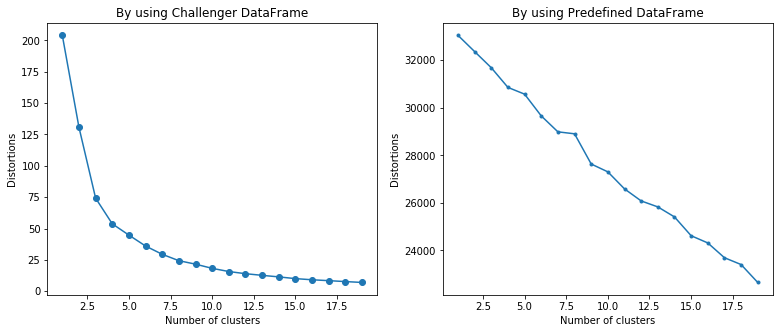

In [36]:
# calculate distortion for a range of number of cluster in a density approach.
distortions_challenger = []
K=20
for k in range(1, K):
    km = KMeans(
        n_clusters=k,random_state=10
    )
    km.fit(X)
    distortions_challenger.append(km.inertia_)

distortions_predefined = []
for k in range(1, K):
    km = KMeans(
        n_clusters=k,random_state=10
    )
    km.fit(X1)
    distortions_predefined.append(km.inertia_)   
#Plot
x=range(1, K)
plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)
plt.plot(x, distortions_challenger, 'o-')
plt.xlabel('Number of clusters')
plt.title('By using Challenger DataFrame')
plt.ylabel('Distortions')

plt.subplot(1, 2, 2)
plt.plot(x, distortions_predefined, '.-')
plt.xlabel('Number of clusters')
plt.title('By using Predefined DataFrame')
plt.ylabel('Distortions')

plt.show()

In the results shown above, Is possible confirm the hypothesis previously described. Elbow test graph for the Predefined DataFrame have worse results than the Challenger DataFrame.
Since was difficult detect the appropiate curve cutoff to determine the best K for the challenger DataFrame, an iterative algorithm to generate models for each possible K was implemented. The silhouette for every model was computed and compared between each others.

#### 2) The K-Means Implementation

For n_clusters = 2 The average silhouette_score is : 0.376156371231
For n_clusters = 3 The average silhouette_score is : 0.417341041324
For n_clusters = 4 The average silhouette_score is : 0.392261511996
For n_clusters = 5 The average silhouette_score is : 0.38625204354
For n_clusters = 6 The average silhouette_score is : 0.399649277407
For n_clusters = 7 The average silhouette_score is : 0.374153590452
For n_clusters = 8 The average silhouette_score is : 0.381233160822
For n_clusters = 9 The average silhouette_score is : 0.38904659091
For n_clusters = 10 The average silhouette_score is : 0.408542952122


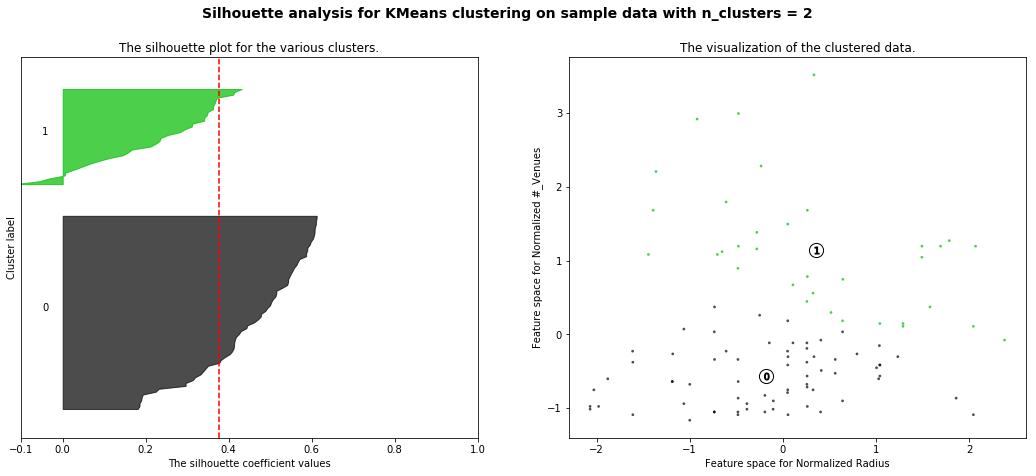

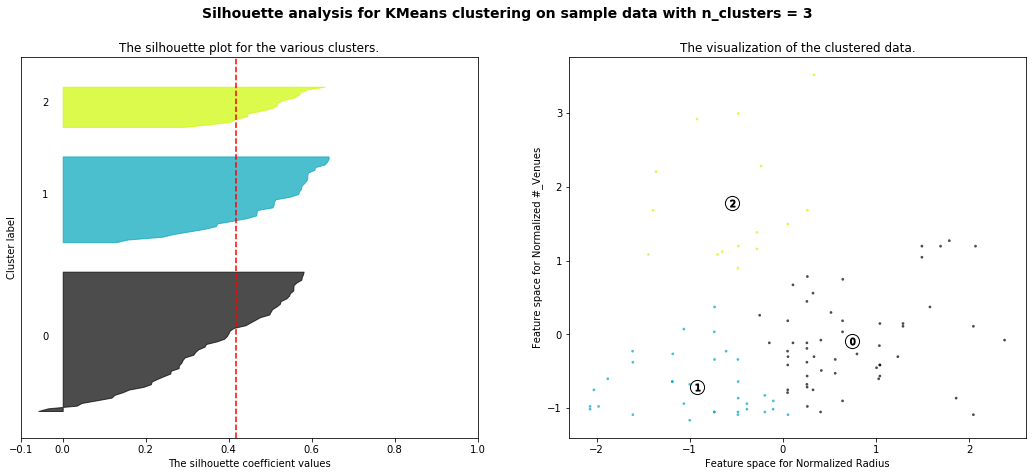

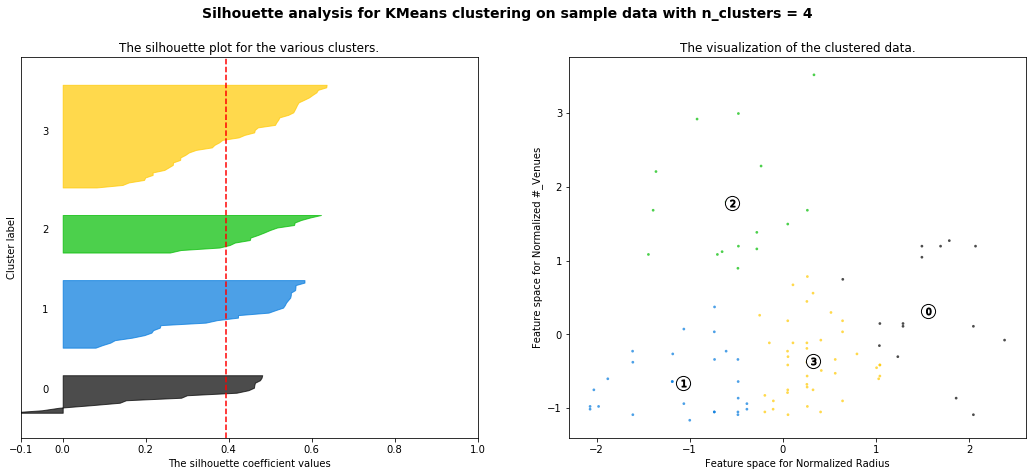

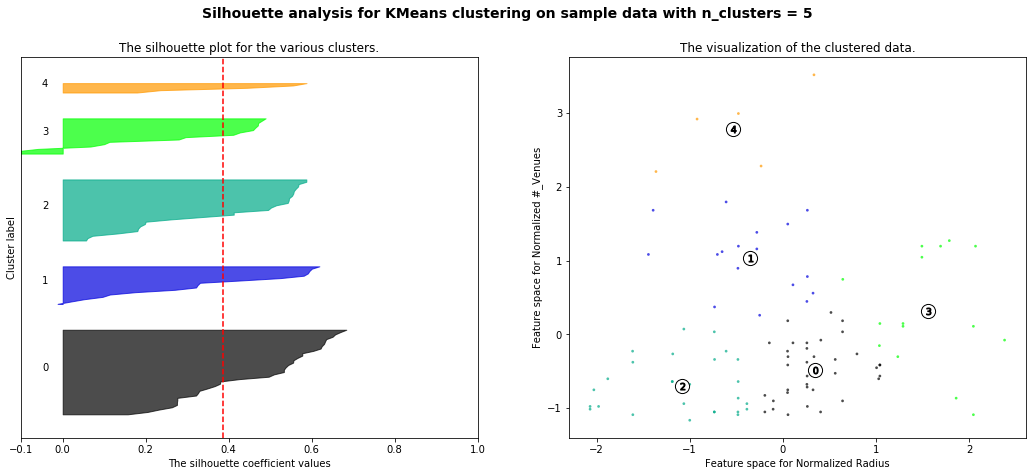

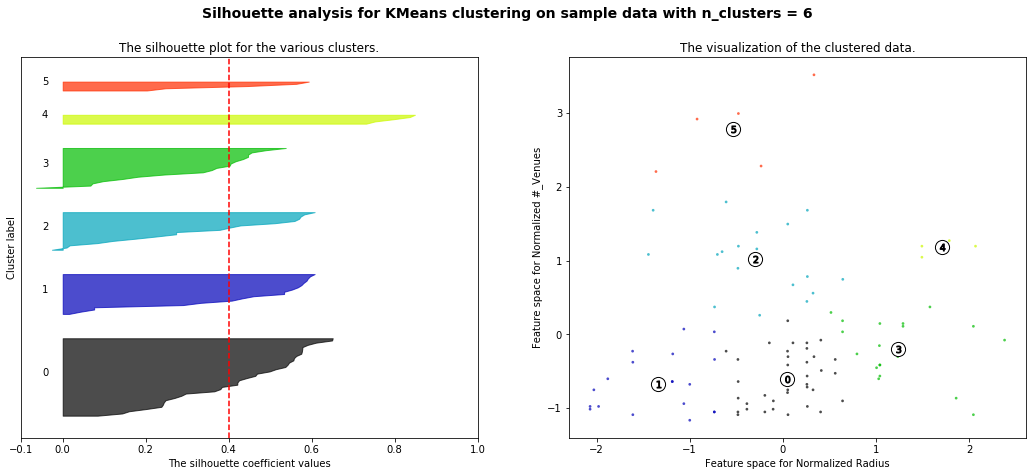

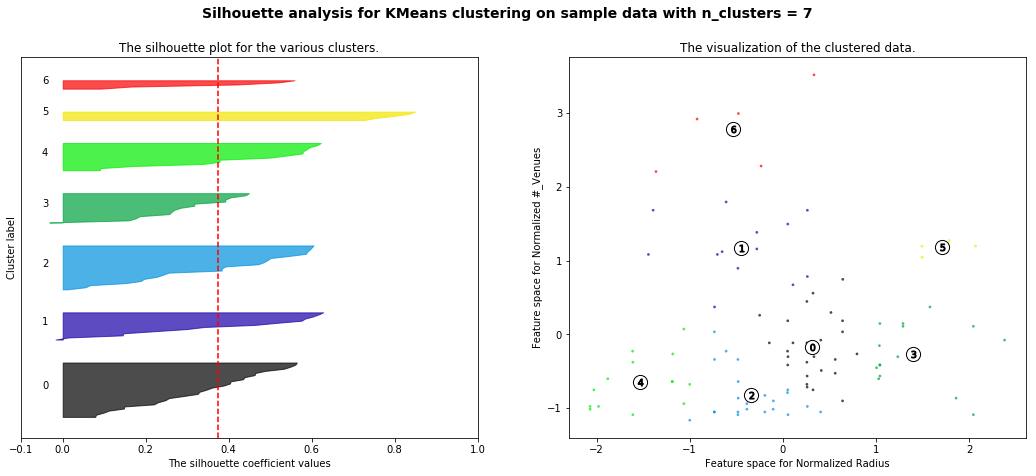

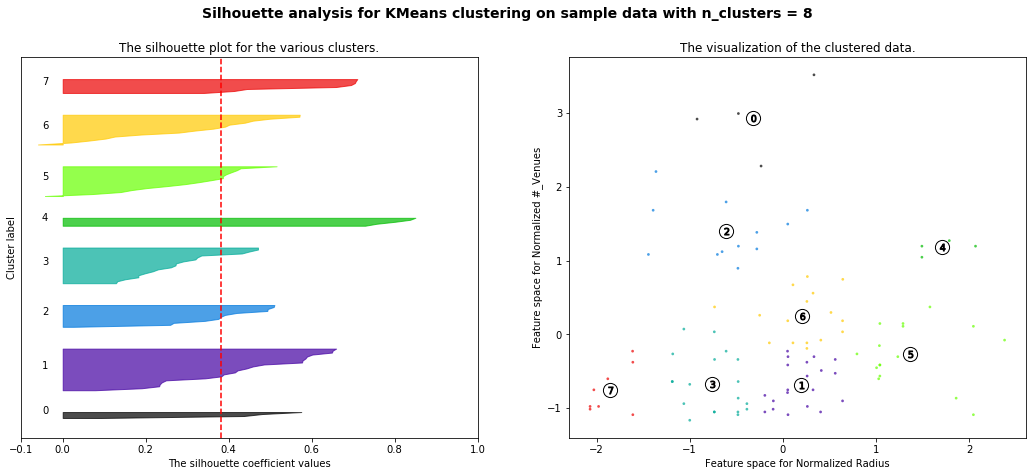

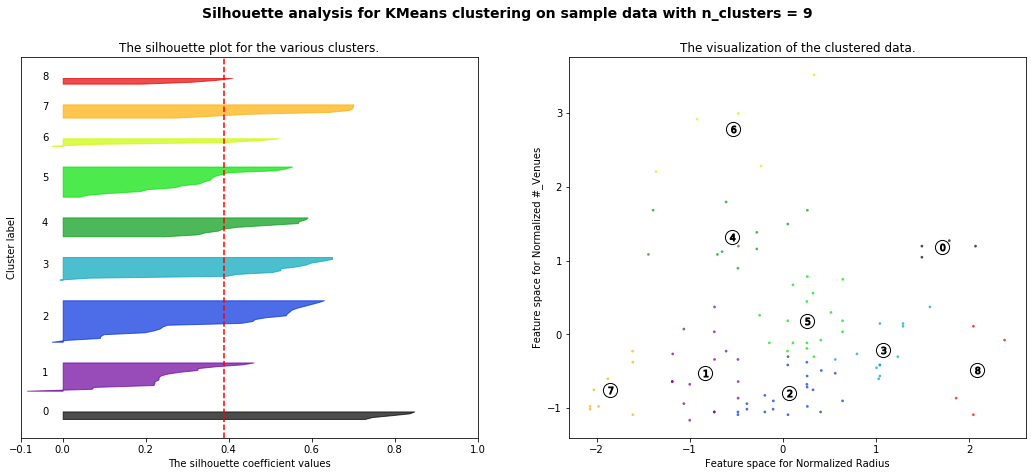

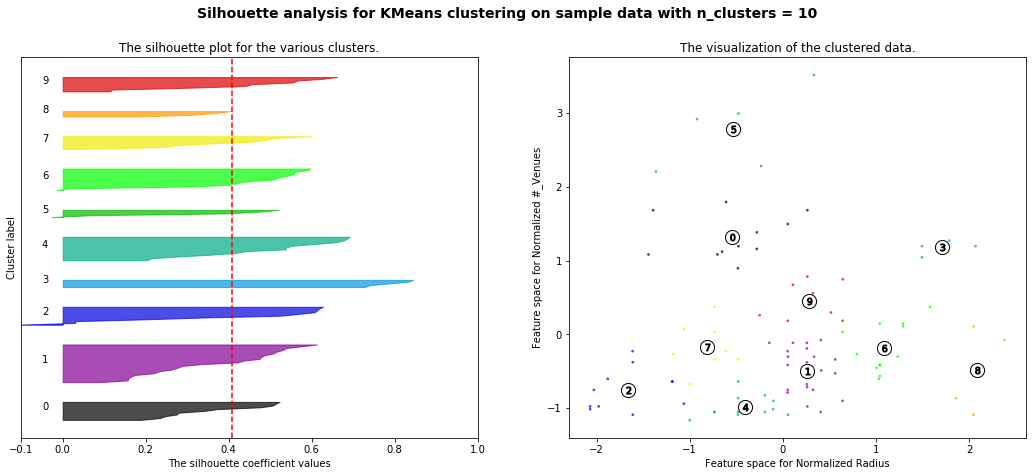

In [37]:

range_n_clusters=[2, 3,4,5,6,7,8,9,10]
for n_clusters in  range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for Normalized Radius")
    ax2.set_ylabel("Feature space for Normalized #_Venues")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

As the implementation results shown: The best silhouette_score belongs to the K=3 model.

#### 3) The best model was selected and cluster label recovered

In [38]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters,  random_state=10).fit(X)

# check cluster labels generated for each row in the dataframe
cluster_label=kmeans.labels_ 
cluster_label

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

## 5. Results

In this section every cluster is named by using its main characteristics, also the results are shown in a map. 

####  5.1 The DataFrame with the analysis results was created

In [39]:
toronto_results=clustering_toronto[["PostalCode", "Radius", "#_Venues"]]
toronto_results["Cluster"]=cluster_label
toronto_results[0:5]

,PostalCode,Radius,#_Venues,Cluster
0,M1B,1698.0,36,0
1,M1C,1625.0,10,0
2,M1E,1205.0,26,0
3,M1G,913.0,4,1
4,M1H,913.0,25,0


In [40]:
No_venues = np.setdiff1d(df_4square['PostalCode'].values,venues['PostalCode'].unique())
df_4square=df_4square[df_4square['PostalCode']!=No_venues[0]]
df_4square.reset_index(drop=True, inplace=True) 
df_4square[0:5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Radius
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0


In [41]:
toronto_results["Neighborhoods"]=df_4square["Neighborhood"]
toronto_results["Latitude"]=df_4square["Latitude"]
toronto_results["Longitude"]=df_4square["Longitude"]
toronto_results.sample(n=5)

,PostalCode,Radius,#_Venues,Cluster,Neighborhoods,Latitude,Longitude
63,M5P,701.0,4,1,"Forest Hill North, Forest Hill West",43.696948,-79.411307
6,M1K,1113.0,24,0,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
76,M6J,703.0,113,2,"Little Portugal, Trinity",43.647927,-79.419750
31,M3L,739.0,8,1,Downsview West,43.739015,-79.506944
20,M2L,1051.0,5,0,"Silver Hills, York Mills",43.757490,-79.374714


The top five common venue_categories for each cluster were generated. 

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [43]:
toronto_grouped=pd.merge(toronto_grouped, toronto_results[["PostalCode", "Cluster"]], on='PostalCode', how='inner')
toronto_grouped[0:5]

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / 

In [44]:
cluster_venues=toronto_grouped.groupby("Cluster").sum()
cluster_venues.reset_index(inplace=True)
cluster_venues

,Cluster,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Casino,Castle,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Dongbei Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundry Service,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pilates Studio,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Pub,Racecourse,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Ski Area,Ski Chalet,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,South American Restaurant,Southern / Sou

In [45]:
# Get modes for each cluster.
num_top_venues=5
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
clusters_venues_sorted = pd.DataFrame(columns=columns)
clusters_venues_sorted['Cluster'] = cluster_venues['Cluster']

for ind in np.arange(cluster_venues.shape[0]):
    clusters_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_venues.iloc[ind, :], num_top_venues)

clusters_venues_sorted.head()

,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Coffee Shop,Park,Pizza Place,Grocery Store,Pharmacy
1,1,Park,Coffee Shop,Café,Pizza Place,Pharmacy
2,2,Coffee Shop,Café,Bar,Pizza Place,Italian Restaurant


In [46]:
cluster_describe=toronto_results.groupby("Cluster")[["Radius", "#_Venues"]].mean()
cluster_describe.reset_index(inplace=True)
cluster_describe["Count"]=toronto_results.groupby("Cluster")[["PostalCode"]].count().values
cluster_describe=pd.merge(cluster_describe, clusters_venues_sorted, on='Cluster', how='inner')

The dataframe with main characteristics was created:

In [47]:
cluster_describe

,Cluster,Radius,#_Venues,Count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,1182.792453,30.547170,53,Coffee Shop,Park,Pizza Place,Grocery Store,Pharmacy
1,1,526.212121,14.181818,33,Park,Coffee Shop,Café,Pizza Place,Pharmacy
2,2,677.687500,80.625000,16,Coffee Shop,Café,Bar,Pizza Place,Italian Restaurant


The list of conclusions from the main characteristics table:


1) The density similarity between cluster 1 and 0 was obvious (15 venues per 500 meters radius). 

2) The both clusters (1,0) have common characteristics in their top 5 list (Park venues).

3) The only difference between clusters is the radius.

4) The cluster 2 have the higher venues density.

Thus, the points 1, 2 and 3 have shown that the best way to describe the clusters 1, 0 is "Small Outsider" and "Large Outsider". The last point has described that the venues density or variety is its most important attribute.

In [48]:
cluster_names=np.array(["Large Outsider", "Small Outsider", "Variety"] )
cluster_describe["Cluster_Name"]=cluster_names
cluster_describe

,Cluster,Radius,#_Venues,Count,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Cluster_Name
0,0,1182.792453,30.547170,53,Coffee Shop,Park,Pizza Place,Grocery Store,Pharmacy,Large Outsider
1,1,526.212121,14.181818,33,Park,Coffee Shop,Café,Pizza Place,Pharmacy,Small Outsider
2,2,677.687500,80.625000,16,Coffee Shop,Café,Bar,Pizza Place,Italian Restaurant,Variety


#### 5.2 Graph the results

In [49]:
toronto_results=pd.merge(toronto_results, cluster_describe[["Cluster","Cluster_Name"]] , on='Cluster', how='inner')
toronto_results[0:5]

,PostalCode,Radius,#_Venues,Cluster,Neighborhoods,Latitude,Longitude,Cluster_Name
0,M1B,1698.0,36,0,"Rouge, Malvern",43.806686,-79.194353,Large Outsider
1,M1C,1625.0,10,0,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Large Outsider
2,M1E,1205.0,26,0,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Large Outsider
3,M1H,913.0,25,0,Cedarbrae,43.773136,-79.239476,Large Outsider
4,M1J,1302.0,22,0,Scarborough Village,43.744734,-79.239476,Large Outsider


In [50]:
toronto_results.sample(n=10)


,PostalCode,Radius,#_Venues,Cluster,Neighborhoods,Latitude,Longitude,Cluster_Name
80,M6G,701.0,24,1,Christie,43.669542,-79.422564,Small Outsider
15,M1X,1698.0,4,0,Upper Rouge,43.836125,-79.205636,Large Outsider
101,M6S,912.0,73,2,"Runnymede, Swansea",43.651571,-79.484450,Variety
5,M1K,1113.0,24,0,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,Large Outsider
69,M5G,256.0,23,1,Central Bay Street,43.657952,-79.387383,Small Outsider
52,M9W,1830.0,31,0,Northwest,43.706748,-79.594054,Large Outsider
55,M3M,739.0,6,1,Downsview Central,43.728496,-79.495697,Small Outsider
66,M4T,601.0,5,1,"Moore Park, Summerhill East",43.689574,-79.383160,Small Outsider
31,M5M,1145.0,53,0,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,Large Outsider
21,M2P,1023.0,25,0,York Mills West,43.752758,-79.400049,Large Outsider


In [51]:
# Matplotlib and associated plotting modules
import matplotlib.colors as colors
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
Toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radius to map
for lat, lng, poi, r, cluster, name in zip(toronto_results['Latitude'], toronto_results['Longitude'], toronto_results['Neighborhoods'], toronto_results["Radius"], toronto_results['Cluster'],toronto_results['Cluster_Name']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(Toronto_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(Toronto_map) 
Toronto_map

#### 5.3 Conclusions:


The map above shows the distribution of the cluster members:
1) The red cluster (0) named "Large Outsiders" is distributed on the Toronto periphery.
2) The purple cluster (1) named "Small Outsiders" is distributed nearby to downtown with an Outlier nearby to Periphery.
3) The green cluster (2) named "Variety" is distributed along the Downtown. A single outlier is viewed on the North Toronto Periphery


This kind of anlysis could be used for real-state marketing and also for demand planning, supply chaind etc.